In [24]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import time
import warnings

from sklearn.utils import resample, shuffle
from premade_funcs import load_data
from sklearn.neural_network import MLPClassifier
import sklearn.metrics

Just load_and_plot_data code here:

In [3]:
data_dir = os.path.abspath("data_fashion/")
test_x, train_x, train_y_df, valid_x, valid_y_df = load_data(data_dir)

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)
Contents of test_x.csv: arr of shape (600, 784)


## 1A - Dataset Exploration

In [18]:
fashion_class = ['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']

train_num = [len(train_y_df[train_y_df["class_name"]=="dress"]), 
           len(train_y_df[train_y_df["class_name"]=="pullover"]),
           len(train_y_df[train_y_df["class_name"]=="top"]),
           len(train_y_df[train_y_df["class_name"]=="trouser"]),
           len(train_y_df[train_y_df["class_name"]=="sandal"]),
           len(train_y_df[train_y_df["class_name"]=="sneaker"])]

valid_num = [len(valid_y_df[valid_y_df["class_name"]=="dress"]), 
           len(valid_y_df[valid_y_df["class_name"]=="pullover"]),
           len(valid_y_df[valid_y_df["class_name"]=="top"]),
           len(valid_y_df[valid_y_df["class_name"]=="trouser"]),
           len(valid_y_df[valid_y_df["class_name"]=="sandal"]),
           len(valid_y_df[valid_y_df["class_name"]=="sneaker"])]

In [19]:
print(train_num)
print(valid_num)

[400, 100, 1, 1, 800, 800]
[100, 100, 100, 100, 100, 100]


In [22]:
fashion = {'classes': pd.Series(fashion_class), 'train': pd.Series(train_num), 'valid': pd.Series(valid_num)}
fashion_df = pd.DataFrame(data=fashion, index=[0, 1, 2, 3, 4, 5])

In [23]:
fashion_df #sample in training set is super skewed! 

,classes,train,valid
0,dress,400,100
1,pullover,100,100
2,top,1,100
3,trouser,1,100
4,sandal,800,100
5,sneaker,800,100


## 1B- Model Development

In [42]:
n_runs = 4
batch_size = [1, 5, 50, 100]
max_iter_per_run = 100

tr_balacc_arr = np.ones(n_runs) 
va_balacc_arr = np.ones(n_runs)
tr_loss_arr = np.ones(n_runs)
va_loss_arr = np.ones(n_runs)

Trying different batch sizes per run - found NO DIFFERENCE made by batch size :(

In [58]:
for size in batch_size:
    
    for run_id, random_state in enumerate(range(n_runs)):
        
        start_time_sec = time.time()
        mlp = MLPClassifier(
            hidden_layer_sizes=[1], #per the spec. Don't touch
            activation='relu',
            alpha=0.0001,
            tol=1e-5,
            max_iter=max_iter_per_run,
            random_state=random_state,
            solver='lbfgs', #better for smaller & sparse training sets
            batch_size=size,
            early_stopping= True
            )
        with warnings.catch_warnings(record=True) as warn_list:
            mlp.fit(train_x, train_y_df['class_uid'])
        elapsed_time_sec = time.time() - start_time_sec
        mlp.did_converge = True if len(warn_list) == 0 else False

        # compute the log loss on training set and test set
        tr_log_loss = sklearn.metrics.log_loss(train_y_df['class_uid'], mlp.predict_proba(train_x)) / np.log(2)
        va_log_loss = sklearn.metrics.log_loss(valid_y_df['class_uid'], mlp.predict_proba(valid_x)) / np.log(2)
        
        tr_loss_arr[run_id-1] = tr_log_loss
        va_loss_arr[run_id-1] = va_log_loss

        # compute the error rate on the training set and test set
        tr_balacc = sklearn.metrics.balanced_accuracy_score(train_y_df['class_uid'], mlp.predict(train_x))
        va_balacc = sklearn.metrics.balanced_accuracy_score(valid_y_df['class_uid'], mlp.predict(valid_x))
        
        tr_balacc_arr[run_id-1] = tr_balacc
        va_balacc_arr[run_id-1] = va_balacc

    
        print(
            'batch size %3d: run %d/%d done after %5.1f sec | %13s after %3d iter | tr err %.3f | te err %.3f' % (
            size, 
            run_id + 1, n_runs, elapsed_time_sec,
            'yes converged' if mlp.did_converge else 'NOT converged',
            max_iter_per_run,
            tr_balacc, va_balacc))

batch size   1: run 1/4 done after   0.1 sec | yes converged after 100 iter | tr err 0.167 | te err 0.167
batch size   1: run 2/4 done after   0.0 sec | yes converged after 100 iter | tr err 0.167 | te err 0.167
batch size   1: run 3/4 done after   0.1 sec | yes converged after 100 iter | tr err 0.167 | te err 0.167
batch size   1: run 4/4 done after   0.0 sec | yes converged after 100 iter | tr err 0.167 | te err 0.167
batch size   5: run 1/4 done after   0.1 sec | yes converged after 100 iter | tr err 0.167 | te err 0.167
batch size   5: run 2/4 done after   0.0 sec | yes converged after 100 iter | tr err 0.167 | te err 0.167
batch size   5: run 3/4 done after   0.0 sec | yes converged after 100 iter | tr err 0.167 | te err 0.167
batch size   5: run 4/4 done after   0.1 sec | yes converged after 100 iter | tr err 0.167 | te err 0.167
batch size  20: run 1/4 done after   0.0 sec | yes converged after 100 iter | tr err 0.167 | te err 0.167
batch size  20: run 2/4 done after   0.0 sec |

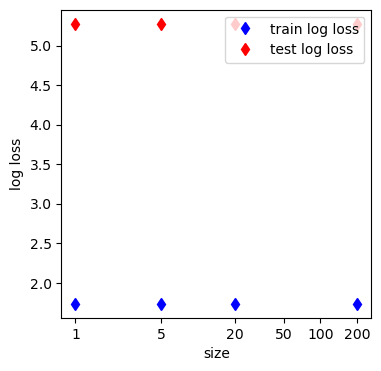

In [63]:
fig, loss_ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharex=True, sharey=True)

for run_id in range(n_runs):
    tr_label = 'train log loss' if run_id == 0 else ''
    te_label = 'test log loss' if run_id == 0 else ''
    
    loss_ax.plot(np.log2(batch_size[run_id-1]), tr_loss_arr[run_id-1], 'bd', label=tr_label)
    loss_ax.plot(np.log2(batch_size[run_id-1]), va_loss_arr[run_id-1], 'rd', label=te_label)

loss_ax.set_xticks(np.log2(batch_size));
loss_ax.set_xticklabels(batch_size);
loss_ax.xaxis.grid(False);


loss_ax.set_ylabel('log loss');
loss_ax.set_xlabel('size');
loss_ax.legend(loc='upper right');

### Use sklearn's resample
THis will ensure that ML model donesn't include towards majority class.
https://towardsdatascience.com/heres-what-i-ve-learnt-about-sklearn-resample-ab735ae1abc4. 

In [81]:
#getting index for each class in training set:
top_int = train_y_df.index[train_y_df['class_name']=='top']    #index 1
trous_int = train_y_df.index[train_y_df['class_name']=='trouser']    #index 11
dress_int =(train_y_df.index[train_y_df['class_name']=='dress']).tolist()
pull_int =(train_y_df.index[train_y_df['class_name']=='pullover']).tolist()
sneaker_int =(train_y_df.index[train_y_df['class_name']=='sneaker']).tolist()
sandal_int =(train_y_df.index[train_y_df['class_name']=='sandal']).tolist()


In [100]:
x_train_2 = np.zeros((405, 784))
x_train_2[0, :] = train_x[top_int, :]   #loading top
assert(train_x[1, :].all()==x_train_2[0, :].all())

x_train_2[1, :] = train_x[trous_int, :] #loadnig trousers
x_train_2[2:102, :] = train_x[pull_int, :]
assert(train_x[3, :].all()==x_train_2[pull_int[1], :].all())    #checking

x_train_2[103:203, :] = train_x[dress_int[0:100], :]
x_train_2[204:304, :] = train_x[sandal_int[0:100], :]
x_train_2[305:405, :] = train_x[sneaker_int[0:100], :]

1    0
Name: class_uid, dtype: int64


In [ ]:
y_train_2= np.zeros((405,1))
y_train_2[0, :] = 0 #top
y_train_2[1, :] = 1  #trousers
y_train_2[2:102, :] = 2 #pullovers
y_train_2[103:203, :] = 3    #dress
y_train_2[204:304, :]= 5    #sandal
y_train_2[305:, :] = 7  #sneaker

In [132]:
n_runs2= 4
batch_size2 = [1, 5, 50, 100]
max_iter_per_run2 = 10000

tr_balacc_arr2 = np.ones(5) 
va_balacc_arr2 = np.ones(5)
tr_loss_arr2 = np.ones(5)
va_loss_arr2 = np.ones(5)

In [134]:
for size in batch_size2:
    
    for random_state in [1, 2, 3, 4, 5]:
        
        start_time_sec = time.time()
        mlp2 = MLPClassifier(
            hidden_layer_sizes=[1], #per the spec. Don't touch
            activation='relu',
            alpha=0.0001,
            tol=1e-5,
            max_iter=max_iter_per_run2,
            random_state=random_state,
            solver='lbfgs', #better for smaller & sparse training sets
            batch_size=size,
            early_stopping= True
            )
        with warnings.catch_warnings(record=True) as warn_list:
            mlp2.fit(x_train_2, y_train_2)
        elapsed_time_sec = time.time() - start_time_sec
        mlp2.did_converge = True if len(warn_list) == 0 else False

        # compute the log loss on training set and test set
        tr_log_loss2 = sklearn.metrics.log_loss(y_train_2, mlp2.predict_proba(x_train_2)) / np.log(2)
        va_log_loss2 = sklearn.metrics.log_loss(valid_y_df['class_uid'], mlp2.predict_proba(valid_x)) / np.log(2)
        
        tr_loss_arr2[random_state-1] = tr_log_loss2
        va_loss_arr2[random_state-1] = va_log_loss2

        # compute the error rate on the training set and test set
        tr_balacc2 = sklearn.metrics.balanced_accuracy_score(y_train_2, mlp2.predict(x_train_2))
        va_balacc2 = sklearn.metrics.balanced_accuracy_score(valid_y_df['class_uid'], mlp2.predict(valid_x))
        
        tr_balacc_arr2[random_state-1] = tr_balacc2
        va_balacc_arr2[random_state-1] = va_balacc2

    
        print(
            'batch size %3d: run %d/%d done after %5.1f sec | %13s after %3d iter | tr err %.3f | te err %.3f' % (
            size, 
            random_state + 1, n_runs, elapsed_time_sec,
            'yes converged' if mlp2.did_converge else 'NOT converged',
            max_iter_per_run2,
            tr_balacc2, va_balacc2))

batch size   1: run 2/4 done after   0.0 sec | NOT converged after 1000 iter | tr err 0.167 | te err 0.167
batch size   1: run 3/4 done after   0.0 sec | NOT converged after 1000 iter | tr err 0.167 | te err 0.167
batch size   1: run 4/4 done after   0.0 sec | NOT converged after 1000 iter | tr err 0.167 | te err 0.167
batch size   1: run 5/4 done after   0.0 sec | NOT converged after 1000 iter | tr err 0.167 | te err 0.167
batch size   1: run 6/4 done after   0.0 sec | NOT converged after 1000 iter | tr err 0.292 | te err 0.167
batch size   5: run 2/4 done after   0.0 sec | NOT converged after 1000 iter | tr err 0.167 | te err 0.167
batch size   5: run 3/4 done after   0.0 sec | NOT converged after 1000 iter | tr err 0.167 | te err 0.167
batch size   5: run 4/4 done after   0.0 sec | NOT converged after 1000 iter | tr err 0.167 | te err 0.167
batch size   5: run 5/4 done after   0.0 sec | NOT converged after 1000 iter | tr err 0.167 | te err 0.167
batch size   5: run 6/4 done after   

c:\Users\leigh\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leigh\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leigh\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


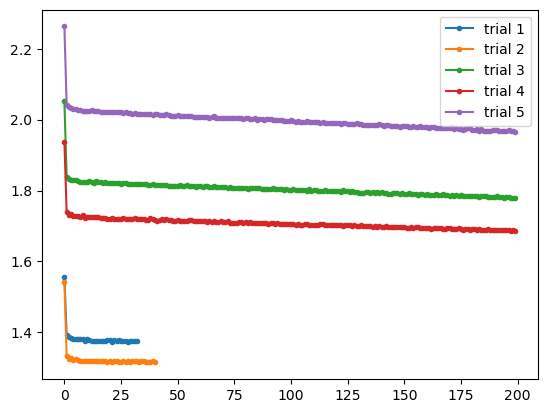

In [123]:
for trial in [1, 2, 3, 4, 5]:
    mlp_1hidden_batchsize25 = sklearn.neural_network.MLPClassifier(
        hidden_layer_sizes=[1],
        activation='relu',
        solver='sgd',
        learning_rate_init=0.05,
        random_state=trial,
        batch_size=25,
        )
    
    # Fit the model to training data
    mlp_1hidden_batchsize25.fit(train_x, train_y_df['class_uid'])
    
    # Visualize the trace of the loss
    plt.plot(mlp_1hidden_batchsize25.loss_curve_, '.-', label='trial %d' % trial)
    
plt.legend();

tr_pred = mlp_1hidden_batchsize25.predict(train_x)
tr_acc = sklearn.metrics.balanced_accuracy_score(train_y_df['class_uid'], tr_pred)



In [124]:
print(tr_acc)

0.16666666666666666
